In [2]:
###############################
# Import the necessary modules
###############################

# The PyBullet physics simulation library
import pybullet as pb
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt

In [100]:
#################################################################
# Forward and Inverse kinematics modules for the serial-2R robot
#################################################################

def forward_kinematics(theta1, theta2, l1, l2):
    '''
    Forward kinematics module for a serial-2R chain.
    The base of the manipulator is assumed to be placed at the
    coordinates [0,0].
    All the joints allow rotation about the positive Z-axis.
    Args:
    --- theta1: Angle between the link l1 and the positive x-axis (in radians)
    --- theta2: Relative angle between link l1 and link l2 (in radians)
    --- l1: Length of link l1 (in m)
    --- l2: Length of link l2 (in m)
    Ret:
    --- [x, y]: Position co-ordinates of the end-effector (in m)
    '''
    x = l1*math.cos(theta1) + l2*math.cos(theta1 + theta2)
    y = l1*math.sin(theta1) + l2*math.sin(theta1 + theta2)
    return [x, y]

def inverse_kinematics(x, y, l1, l2, branch=1):
    '''
    Inverse kinematics modules for the serial-2R manipulator.
    The base of the manipulator is placed at [0,0].
    Axis of rotation is the Z+ axis.
    Args:
    --- x : X co-ordinate of the end-effector
    --- y : Y co-ordinate of the end-effector
    --- l1: Length of link l1
    --- l2: Length of link l2
    --- branch: Branch of the inverse kinematics solution.
    Ret:
    --- valid: Binary variable indicating if the solution is valid or not
    --- [theta1, theta2]: Angles made by link l1 w.r.t X+ axis and the relative
                    angle between links l1 and l2 respectively.
    '''
    a = 2*x*l2
    b = 2*y*l2
    c =  l1*l1 - x*x - y*y  - l2*l2 
    psi = math.atan2(b, a)
    d = -c/math.sqrt(a*a + b*b)
    
    if (d < -1) or (d > 1):
        print("Position out of workspace.")
        return False, [0,0]
    if branch == 1:
        theta12 = psi + math.acos(-c/math.sqrt(a*a + b*b))
    else:
        theta12 = psi - math.acos(-c/math.sqrt(a*a + b*b))
        
    theta1 = math.atan2((y - l2*math.sin(theta12))/l1, (x - l2*math.cos(theta12))/l1)
    return True, [theta1, theta12-theta1]

In [102]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = pb.connect(pb.GUI) # or p.GUI


# Load the URDF of the plane that forms the ground
pb.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = pb.loadURDF("plane.urdf")


# Load the URDF of the robot
scara = pb.loadURDF("scara_robot_left.urdf")

In [96]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
pb.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
pb.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
#p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [83]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
pb.setJointMotorControl2(scara, 1, pb.VELOCITY_CONTROL, force=0)
pb.setJointMotorControl2(scara, 2, pb.VELOCITY_CONTROL, force=0)

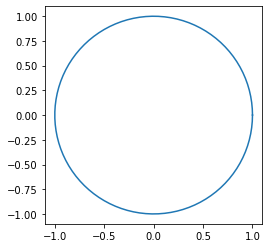

In [4]:
theta = np.linspace(0, 2*np.pi, 100)

# the radius of the circle
r = 1

# compute x1 and x2
x1 = r*np.cos(theta)
x2 = r*np.sin(theta)

# create the figure
fig, ax = plt.subplots(1)
ax.plot(x1, x2)
ax.set_aspect(1)
plt.show()

In [84]:
#######################################
# Define functions for the trajectories
#######################################


def trajectory1(t):
    theta = np.linspace(0, 2*np.pi, 100)

    # the radius of the circle
    r = t

    # compute x1 and x2
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)
    for i in range(100):
        control(np.array([x1[i],x2[i]]))
    

    
    
    



In [91]:
##########################################
# Control loop to follow the trajectory
##########################################
# Kinematics for serial-2R
def control(numpy_array):
    pt_des = numpy_array # or p2

    valid, [theta1, theta2] = inverse_kinematics(pt_des[0], pt_des[1], 1, 1)


    dt     = 0.0001 # simulation time-step
    p_gain = 200 # Proportional gain
    d_gain = 10 # Derivative gain
    error  = 0
    error_old = 0
    desired_pos = np.array([theta1, theta2])
    for _ in range(1000):
        pos1, _, _, _ = pb.getJointState(scara,1)
        pos2, _, _, _ = pb.getJointState(scara,2)
        pos = np.array([pos1, pos2])
        error_old = error
        error = desired_pos - pos
        error_d = (error - error_old)/dt
        control_force = p_gain * error + d_gain * error_d
        pb.setJointMotorControlArray(scara, [1,2], pb.TORQUE_CONTROL, forces=control_force)
        pb.stepSimulation()


    # Check if the robot has reached the desired position
    pos1, _, _, _ = pb.getJointState(scara, 1)
    pos2, _, _, _ = pb.getJointState(scara, 2)
    pt_act = forward_kinematics(pos1, pos2, 1, 1)

    print(pt_des)
    print(pt_act)





In [92]:
trajectory1(1)

[1. 1.]
[1.0000000000000113, 1.0000000000000004]
[0.99798668 1.06342392]
[0.9969745613201204, 1.063996565175566]
[0.99195481 1.12659245]
[0.9907980344365145, 1.127210505302631]
[0.9819287  1.18925124]
[0.9807174438802492, 1.1898698033995982]
[0.9679487  1.25114799]
[0.9666961928525779, 1.2517586704746746]
[0.95007112 1.31203345]
[0.9487797655932524, 1.3126329981489966]
[0.92836793 1.37166246]
[0.9270387767118943, 1.3722483502661673]
[0.90292654 1.42979491]
[0.9015605570623669, 1.4303647680299987]
[0.87384938 1.48619674]
[0.8724476693488578, 1.486748249138525]
[0.84125353 1.54064082]
[0.839817337291684, 1.5411717587379068]
[0.80527026 1.59290793]
[0.8038009516318063, 1.5934161527709696]
[0.76604444 1.64278761]
[0.7645435380058858, 1.6432710616022386]
[0.72373404 1.69007901]
[0.7222031725504833, 1.6905357372540921]
[0.67850941 1.73459171]
[0.676950345323912, 1.7350198617595995]
[0.63055267 1.77614646]
[0.62896727379433, 1.7765443134989045]
[0.58005691 1.81457595]
[0.5784471691146121, 1.8

In [98]:
pb.disconnect()